## Importing libraries and data

In [1]:
#import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

# import libraries for modelling
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier

In [ ]:
#we are using a dataset from kaggle. Don't forget to load a kaggle.json file before running this cell
! pip install kaggle

! mkdir ~/.kaggle

! cp kaggle.json ~/.kaggle/

! chmod 600 ~/.kaggle/kaggle.json

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!pip install torch==1.13.1
! pip install sdv
! pip install faker
! pip install realtabformer

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 887.4/887.4 MB 1.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 849.3/849.3 kB 40.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.1/317.1 MB 3.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 557.1/557.1 MB 2.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.0/21.0 MB 75.2 MB/s eta 0:00:00
  Attempting uninstall: torch
    Found existing installation: torch 2.0.0+cu118
    Uninstalling torch-2.0.0+cu118:
      Successfully uninstalled torch-2.0.0+cu118
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchvision 0.15.1+cu118 requires torch==2.0.0, but you have torch 1.13.1 which is incompatible.
torchtext 0.15.1 requires torch==2.0.0, but you have torch

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.5/50.5 kB 5.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 468.7/468.7 kB 38.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 72.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.2/212.2 kB 23.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.9/132.9 kB 17.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 71.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 30.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 17.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 107.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 158.8/158.8 kB 24.9 MB/s eta 0:00:0

In [ ]:
!kaggle datasets download -d incarnyx/car-insurance-fraud

100% 1.82M/1.82M [00:01<00:00, 1.95MB/s]
100% 1.82M/1.82M [00:01<00:00, 1.72MB/s]


In [ ]:
!unzip car-insurance-fraud.zip

Archive:  car-insurance-fraud.zip
  inflating: Dataset.xlsx            


## Synthetic Data Generator

In [ ]:
import pandas as pd
import numpy as np
from faker import Faker
import random
from collections import OrderedDict
from sdv.metadata import SingleTableMetadata
from sdv.single_table import CTGANSynthesizer, GaussianCopulaSynthesizer
import torch
import re
from sdv.metadata import SingleTableMetadata
from realtabformer import REaLTabFormer
 


class Generator:

    def __init__(self, data, architecture, n_samples, num_epochs=None, num_bootstrap = None ,categorical_columns=None, sensitive_columns=None):

        """
        :param n_epochs: the number of epochs used for training, default is 200
        :param num_bootstraps: number of bootstraps for the RealTabFormer, default is 500
        :param n_samples: the number of rows to generate
        :param architecture: the chosen architecture, one of ['CTGAN', 'GaussianCopula', 'RealTabFormer']
        :param data: the data that should be trained on, should be in a pandas dataframe
        :param categorical_columns: a list with categorical columns
        :param sensitive_columns: a dict with sensitive columns and what  category they belong to
        The categories can be found in the faker_categorical function

        The metadata: an sdv metadata object required to call CTGAN and other methods
        Also required for similarity checks
        """
        if num_epochs is not None:
          self.num_epochs = num_epochs
        else: 
          # Default value for RealTabFormer and could be enough for CTGAN
          self.num_epochs = 200
        if num_bootstrap is not None:
          self.num_bootstrap = num_bootstrap
        else: 
          # Set to default for RealTabFormer
          self.num_bootstrap = 500 
        self.n_samples = n_samples
        if architecture in ['CTGAN', 'GaussianCopula', 'RealTabFormer']:
            self.architecture = architecture
        else:
            print('The requested architecture is not available')
            raise ValueError
        print('Retrieving metadata, check with generator.metadata')
        self.data = data
        self.metadata = self.create_metadata()
        self.categorical_columns = categorical_columns
        self.sensitive_columns = sensitive_columns

    def create_metadata(self):
        metadata = SingleTableMetadata()
        metadata.detect_from_dataframe(data=self.data)
        return metadata

    def generate(self):
        """
        Based on the chosen architecture, this function returns synthetically generated data
        :return: synthetic data, a pandas dataframe
        """

        #  TODO: Add more generators, especially PATEGAN or other differentially private ones synthcity seems to have
        #  implementations of these, but I have not been able to import their library

        if self.architecture == "CTGAN":
            model = CTGANSynthesizer(metadata=self.metadata, epochs=self.num_epochs, verbose=True)
            model.fit(self.data)
            synth_data = model.sample(self.n_samples)

        elif self.architecture == "GaussianCopula":
            model = GaussianCopulaSynthesizer(metadata=self.metadata)
            model.fit(self.data)
            synth_data = model.sample(self.n_samples)
        elif self.architecture == "RealTabFormer":
            model = REaLTabFormer(
                      model_type="tabular",
                      epochs = self.num_epochs,
                      gradient_accumulation_steps=4,
                      # Output log each 2O steps
                      logging_steps=20)
            model.fit(self.data, num_bootstrap = self.num_bootstrap)
            synth_data = model.sample(n_samples = self.n_samples)


        return synth_data

    def faker_categorical(self, seed=None):
        """
        Instantiates Faker, generates fake data for it
        WARNING: data generated here should not be used for ML models
        :param seed: int, random seed, defaults
        """

        # TODO: Find a way to make this generalizable, f.e. create many attributes, and return the ones asked

        seed = seed or random.seed()
        # We can initialize the faker with multiple locations: can now draw addresses and names from
        # Germany, US, UK, Spain, France, Italy. Either just a list => all equal weights, or an ordered
        # dictionary in which weights can be specified.
        locale_list = ['de_DE', 'en_US', 'en_GB', 'es_ES', 'fr_FR', 'it_IT']
        fake = Faker(locale_list)
        fake.seed_instance(seed)
        # check whether the ID generated is already in use
        used_ids = set()
        output = []
        for i in range(self.n_samples):
            # select a locale at random => will allow us to generate internally consistent city-country pairs
            # or name/email pairs. Problem is that not all countries might be able to generate all of these
            # attributes. For example Belgium can't create IP-addresses
            locale = np.random.choice(locale_list)
            while True:
                new_id = fake.random_int(min=1, max=self.n_samples)
                if new_id not in used_ids:
                    used_ids.add(new_id)
                    break

            gender = np.random.choice(["Male", "Female"], p=[0.5, 0.5])
            # this works, but it's technical debt, talk to Léo about it
            if gender == "male":
                first_name = fake[locale].first_name_male()
            else:
                first_name = fake[locale].first_name_female()
            last_name = fake[locale].last_name()
            row = {
                "id": new_id,
                "first_name": first_name,
                "last_name": last_name,
                # take everything before @, and replace with first name.lastname
                "email": re.sub(r'^(.*?)@', first_name + "." + last_name + "@", fake[locale].free_email()),
                "gender": gender,
                "ip_address": fake[locale].ipv4_private(),
                "nationality": fake[locale].current_country(),
                "city": fake[locale].city()
            }
            output.append(row)

        df = pd.DataFrame(output, columns=self.sensitive_columns)
        return df

## Similarity check

In [ ]:
from __future__ import annotations

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
from sdv.evaluation.single_table import evaluate_quality

# TODO: ML model performance 


class SimilarityCheck:

    '''
    Check the quality of the synthetic data both visually and with metrics
    '''

    def __init__(self, real_data, synthetic_data, cat_cols, metadata):
        self.real_data = real_data
        self.synthetic_data = synthetic_data
        if cat_cols is not None:
          self.cat_cols = cat_cols
        else:
          self.cat_cols = []
        self.metadata = metadata


    def comparison_columns(self):
        '''
        :return: the KL divergence for numerical variables...
        tested and works
        '''
        quality_report = evaluate_quality(
          real_data=self.real_data,
          synthetic_data=self.synthetic_data,
          metadata=self.metadata)
        print(quality_report)
        print(quality_report.get_details(property_name='Column Shapes'))


    def visual_comparison_columns(self):
        '''
        Plot data in one of three ways:
        1) numeric columns are plotted using the densities
        2) categorical columns with limited categories are plotted with bar plots
        3) categorical columns with many categories do not show the values, if performance looks problematic
        we encourage further exploration of these columns
        '''
        if (self.real_data.columns != self.synthetic_data.columns).all():
            print('Columns in real and synthetic data not the same!')
            return

        fig, ax = plt.subplots(nrows=len(self.real_data.columns), figsize=(10, len(self.real_data.columns)*4))
        fig.tight_layout(pad = 5)
        for i, column in enumerate(self.real_data.columns):
            if column not in self.cat_cols:
                sns.kdeplot(self.real_data[column], ax=ax[i], label='Real', fill=True, color='c')
                sns.kdeplot(self.synthetic_data[column], ax=ax[i], label='Synthetic', fill=True, color='m')
            elif len(self.real_data[column].unique()) <= 5:
                sns.histplot(data = self.real_data,x = column, ax=ax[i],bins = len(self.real_data[column].unique()), label='Real', stat = 'density', color='c',discrete = False,element = 'step')
                sns.histplot(data = self.synthetic_data,x = column, ax=ax[i], bins = len(self.real_data[column].unique()),label='Synthetic', stat = "density", color='m',discrete = False ,element = 'step')
            else:
                sns.histplot(data = self.real_data,x = column, ax=ax[i], label='Real', fill = False,stat = 'density', color='c',discrete = False,element = 'step')
                sns.histplot(data = self.synthetic_data,x = column, ax=ax[i], label='Synthetic', fill = False,stat = "density", color='m',discrete = False ,element = 'step')
                ax[i].set_xticklabels([])
            ax[i].set_title(f'Comparison of {column}')
            ax[i].autoscale_view()
            ax[i].set_xlabel(column)
            ax[i].legend()
        plt.show()

    def compare_correlations(self):
        '''
        Compare correlation matrices
        :return:
        '''
        fig, ax = plt.subplots(figsize=(len(self.real_data.columns), (len(self.real_data.columns))))
        diff_corr = abs(self.real_data.corr() - self.synthetic_data.corr())
        mask = np.tril(np.ones_like(diff_corr, dtype=bool))
        sns.heatmap(diff_corr, mask=mask)
        ax.set_title('Differences in correlation values real and synthetic data')

    def compare_model_performance(self, fitted_model_real, fitted_model_synth, X_test, y_test):
        """
        Method that computes how close the scores of a model trained on the real vs. synthetic
        data are.
        """
        score_real = fitted_model_real.score(X_test, y_test)
        score_synth = fitted_model_synth.score(X_test, y_test)
        print(f"Score on real dataset: {score_real}\nScore on synthetic dataset: {score_synth}")
        return score_real, score_synth

## Use case of FRAUD DETECTION


### Loading the data

In [ ]:
df = pd.read_excel("Dataset.xlsx")
pd.set_option('display.max_columns', None)

In [ ]:
df

,Month,WeekOfMonth,DayOfWeek,Make,AccidentArea,DayOfWeekClaimed,MonthClaimed,WeekOfMonthClaimed,Sex,MaritalStatus,Age,Fault,PolicyType,VehicleCategory,VehiclePrice,FraudFound_P,PolicyNumber,RepNumber,Deductible,DriverRating,Days_Policy_Accident,Days_Policy_Claim,PastNumberOfClaims,AgeOfVehicle,AgeOfPolicyHolder,PoliceReportFiled,WitnessPresent,AgentType,NumberOfSuppliments,AddressChange_Claim,NumberOfCars,Year,BasePolicy,ClaimSize
0,Dec,5,Wednesday,Honda,Urban,Tuesday,Jan,1,Female,Single,21.0,Policy Holder,Sport - Liability,Sport,more than 69000,0,1,12,300,1.0,more than 30,more than 30,none,3 years,26 to 30,No,No,External,none,1 year,3 to 4,1994,Liability,55526.069421
1,Jan,3,Wednesday,Honda,Urban,Monday,Jan,4,Male,Single,34.0,Policy Holder,Sport - Collision,Sport,more than 69000,0,2,15,400,4.0,more than 30,more than 30,none,6 years,31 to 35,Yes,No,External,none,no change,1 vehicle,1994,Collision,59294.455571
2,Oct,5,Friday,Honda,Urban,Thursday,Nov,2,Male,Married,47.0,Policy Holder,Sport - Collision,Sport,more than 69000,0,3,7,400,3.0,more than 30,more than 30,1,7 years,41 to 50,No,No,External,none,no change,1 vehicle,1994,Collision,71756.941320
3,Jun,2,Saturday,Toyota,Rural,Friday,Jul,1,Male,Married,65.0,Third Party,Sedan - Liability,Sport,20000 to 29000,0,4,4,400,2.0,more than 30,more than 30,1,more than 7,51 to 65,Yes,No,External,more than 5,no change,1 vehicle,1994,Liability,7584.153493
4,Feb,1,Saturday,Honda,Urban,Monday,Feb,3,Male,Married,36.0,Third Party,Sport - Collision,Sport,more than 69000,0,7,14,400,1.0,more than 30,more than 30,1,7 years,36 to 40,No,No,External,1 to 2,no change,1 vehicle,1994,Collision,98545.374339
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11560,Nov,4,Thursday,Mazda,Urban,Monday,Nov,4,Male,Married,40.0,Policy Holder,Sedan - Liability,Sport,20000 to 29000,0,15414,9,400,2.0,more than 30,more than 30,1,7 years,36 to 40,Yes,No,External,1 to 2,no change,1 vehicle,1996,Liability,3161.763273
11561,Nov,4,Friday,Chevrolet,Urban,Monday,Nov,4,Male,Single,58.0,Third Party,Sedan - Collision,Sedan,30000 to 39000,0,15415,3,400,4.0,more than 30,more than 30,none,7 years,51 to 65,No,No,External,1 to 2,4 to 8 years,2 vehicles,1996,Collision,6546.369095
11562,Nov,4,Friday,Toyota,Urban,Tuesday,Nov,5,Male,Married,35.0,Policy Holder,Sedan - Collision,Sedan,20000 to 29000,1,15416,5,400,4.0,more than 30,more than 30,2 to 4,6 years,31 to 35,No,No,External,none,no change,1 vehicle,1996,Collision,5333.907501
11563,Dec,1,Monday,Toyota,Urban,Thursday,Dec,2,Female,Married,34.0,Third Party,Sedan - All Perils,Sedan,20000 to 29000,0,15419,6,400,4.0,more than 30,more than 30,none,2 years,31 to 35,No,No,External,more than 5,no change,1 vehicle,1996,All Perils,7618.072430


In [ ]:
df.dtypes

Month                    object
WeekOfMonth               int64
DayOfWeek                object
Make                     object
AccidentArea             object
DayOfWeekClaimed         object
MonthClaimed             object
WeekOfMonthClaimed        int64
Sex                      object
MaritalStatus            object
Age                     float64
Fault                    object
PolicyType               object
VehicleCategory          object
VehiclePrice             object
FraudFound_P              int64
PolicyNumber              int64
RepNumber                 int64
Deductible                int64
DriverRating            float64
Days_Policy_Accident     object
Days_Policy_Claim        object
PastNumberOfClaims       object
AgeOfVehicle             object
AgeOfPolicyHolder        object
PoliceReportFiled        object
WitnessPresent           object
AgentType                object
NumberOfSuppliments      object
AddressChange_Claim      object
NumberOfCars             object
Year    

### Dropping sensitive field without predictive power

In [ ]:
df = df.drop('PolicyNumber',axis = 1)


### Identifying categorical columns and sensitive columns

In [ ]:
cat_col = []
sensitive_cols = ['Sex','Age']

for el in list(df):
  if df[el].dtype == object:
    print(el)
    cat_col.append(el)

Month
DayOfWeek
Make
AccidentArea
DayOfWeekClaimed
MonthClaimed
Sex
MaritalStatus
Fault
PolicyType
VehicleCategory
VehiclePrice
Days_Policy_Accident
Days_Policy_Claim
PastNumberOfClaims
AgeOfVehicle
AgeOfPolicyHolder
PoliceReportFiled
WitnessPresent
AgentType
NumberOfSuppliments
AddressChange_Claim
NumberOfCars
BasePolicy


In [ ]:
for col in df.columns:
    unique_types = df[col].apply(type).unique()
    if len(unique_types) > 1:
        print(col, unique_types)

DayOfWeekClaimed [<class 'str'> <class 'int'>]
MonthClaimed [<class 'str'> <class 'int'>]
PastNumberOfClaims [<class 'str'> <class 'int'>]


In [ ]:
df['PastNumberOfClaims'] = df['PastNumberOfClaims'].astype("string").astype('object')
df['DayOfWeekClaimed'] = df['DayOfWeekClaimed'].astype("string").astype('object')
df['MonthClaimed'] = df['MonthClaimed'].astype("string").astype('object')

### Splitting the dataframe into fraud and non-fraud

In [ ]:
fraud_df = df[df['FraudFound_P'] ==1].drop('FraudFound_P',axis=1)
no_fraud_df = df[df['FraudFound_P'] ==0].drop('FraudFound_P',axis=1)

In [ ]:
for i in list(fraud_df):
  if i not in cat_col:
    print(i,fraud_df[i].dtypes)

WeekOfMonth int64
WeekOfMonthClaimed int64
Age float64
FraudFound_P int64
RepNumber int64
Deductible int64
DriverRating float64
Year int64
ClaimSize float64


The classes (fraud and no fraud are unbalanced). Our goal now is to synthesize both fraud and non-fraud data, but generate additional samples for the fraud data to augment the dataset and rebalance the classes. 

In [ ]:
print(len(fraud_df))
print(len(no_fraud_df))

685
10880


### Generating fraudulent & non-fraudulent data separately

In [ ]:
generator_no_fraud = Generator(num_epochs=2, n_samples=10000, num_bootstrap = 50 ,architecture='RealTabFormer',
                          data=no_fraud_df,
                          categorical_columns=cat_col,
                          sensitive_columns=sensitive_cols)

generator_fraud = Generator(num_epochs=2, n_samples=3000, num_bootstrap = 50 ,architecture='RealTabFormer',
                          data=fraud_df,
                          categorical_columns=cat_col,
                          sensitive_columns=sensitive_cols)

Retrieving metadata, check with generator.metadata
Retrieving metadata, check with generator.metadata


In [ ]:
synth_no_fraud = generator_no_fraud.generate()
synth_fraud = generator_fraud.generate()

Computing the sensitivity threshold...


/usr/local/lib/python3.9/dist-packages/realtabformer/realtabformer.py:566: UserWarning: Duplicate rate (0.0) in the data is zero. The `qt_interval` will be set                     to qt_interval_unique=100.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/realtabformer/realtabformer.py:593: UserWarning: qt_interval adjusted from 100 to 89...
  warnings.warn(


Bootstrap round:   0%|          | 0/50 [00:00<?, ?it/s]

Sensitivity threshold summary:
count    50.000000
mean      0.000321
std       0.002296
min      -0.004693
25%      -0.001278
50%      -0.000081
75%       0.002045
max       0.004743
dtype: float64
Sensitivity threshold: 0.0043950111107633515 qt_max: 0.05


Map:   0%|          | 0/10880 [00:00<?, ? examples/s]

/usr/local/lib/python3.9/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Step,Training Loss
20,2.252400
40,1.133400
60,1.036900
80,0.995600
100,0.965500
120,0.954000
140,0.937800
160,0.925500
180,0.920200
200,0.916800


  0%|          | 0/5385 [00:00<?, ?it/s]

Generated 2 invalid samples out of total 5504 samples generated. Sampling efficiency is: 99.9637%
Critic round: 5,                     sensitivity_threshold: 0.0043950111107633515,                         val_sensitivity: 0.0010745099266585257,                             val_sensitivities: [0.004263559825983534, 0.003607555319082341, 0.003512409627241711, 0.004197208225094673, 0.0015243654345716846, -0.003499577478013211, 0.0015519076085255517, -0.000580107038903324, -0.002777221370223157, 0.001088698319301427, -0.0004248693311633472, 0.0013228067979092954, 0.0009772777064880561, 0.00027244843666864553, 0.0010811868173140088]


  0%|          | 0/10000 [00:00<?, ?it/s]

Generated 2 invalid samples out of total 10112 samples generated. Sampling efficiency is: 99.9802%
Computing the sensitivity threshold...


/usr/local/lib/python3.9/dist-packages/realtabformer/realtabformer.py:566: UserWarning: Duplicate rate (0.0) in the data is zero. The `qt_interval` will be set                     to qt_interval_unique=100.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/realtabformer/realtabformer.py:593: UserWarning: qt_interval adjusted from 100 to 5...
  warnings.warn(


Bootstrap round:   0%|          | 0/50 [00:00<?, ?it/s]

Sensitivity threshold summary:
count    50.000000
mean      0.002865
std       0.009369
min      -0.017566
25%      -0.001903
50%       0.003142
75%       0.008805
max       0.026327
dtype: float64
Sensitivity threshold: 0.018539823008849533 qt_max: 0.05


Map:   0%|          | 0/685 [00:00<?, ? examples/s]

/usr/local/lib/python3.9/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Step,Training Loss
20,2.434200
40,1.335200


  0%|          | 0/339 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 384 samples generated. Sampling efficiency is: 100.0000%
Critic round: 5,                     sensitivity_threshold: 0.018539823008849533,                         val_sensitivity: -0.008056047197640121,                             val_sensitivities: [-0.020752212389380534, -0.00022123893805309978, -0.0186283185840708, -0.010132743362831861, -0.013672566371681419, -0.006238938053097347, -0.006592920353982304, -0.0019911504424778787, -0.010132743362831861, -0.01190265486725664, -0.006238938053097347, -0.0037610619469026574, -0.00942477876106195, 0.004026548672566369, -0.00517699115044248]


  0%|          | 0/3000 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 3072 samples generated. Sampling efficiency is: 100.0000%


### Checking the similarities

In [ ]:
similarity_checker_nofraud = SimilarityCheck(generator_no_fraud.data, synth_no_fraud, cat_col, generator_no_fraud.metadata)
similarity_checker_fraud = SimilarityCheck(generator_fraud.data, synth_fraud, cat_col, generator_fraud.metadata)

In [ ]:
similarity_checker_nofraud.comparison_columns()
similarity_checker_fraud.comparison_columns()

Creating report: 100%|██████████| 4/4 [00:11<00:00,  2.96s/it]



Overall Quality Score: 97.04%

Properties:
Column Shapes: 97.87%
Column Pair Trends: 96.22%
                  Column        Metric  Quality Score
0            WeekOfMonth  KSComplement       0.982850
1     WeekOfMonthClaimed  KSComplement       0.989901
2                    Age  KSComplement       0.983028
3              RepNumber  KSComplement       0.987479
4             Deductible  KSComplement       0.991457
5           DriverRating  KSComplement       0.994705
6                   Year  KSComplement       0.998942
7              ClaimSize  KSComplement       0.971068
8                  Month  TVComplement       0.976953
9              DayOfWeek  TVComplement       0.961201
10                  Make  TVComplement       0.981348
11          AccidentArea  TVComplement       0.972586
12      DayOfWeekClaimed  TVComplement       0.987324
13          MonthClaimed  TVComplement       0.972464
14                   Sex  TVComplement       0.970044
15         MaritalStatus  TVComplement     

Creating report: 100%|██████████| 4/4 [00:06<00:00,  1.69s/it]



Overall Quality Score: 90.58%

Properties:
Column Shapes: 93.22%
Column Pair Trends: 87.94%
                  Column        Metric  Quality Score
0            WeekOfMonth  KSComplement       0.939178
1     WeekOfMonthClaimed  KSComplement       0.955270
2                    Age  KSComplement       0.942771
3              RepNumber  KSComplement       0.930482
4             Deductible  KSComplement       0.937375
5           DriverRating  KSComplement       0.946107
6                   Year  KSComplement       0.975652
7              ClaimSize  KSComplement       0.845019
8                  Month  TVComplement       0.890521
9              DayOfWeek  TVComplement       0.919311
10                  Make  TVComplement       0.876745
11          AccidentArea  TVComplement       0.929268
12      DayOfWeekClaimed  TVComplement       0.929633
13          MonthClaimed  TVComplement       0.865608
14                   Sex  TVComplement       0.956097
15         MaritalStatus  TVComplement     

### Concatenate synthetic dataset (fraud + non-fraud)

In [ ]:
synth_no_fraud['FraudFound_P'] = 0
synth_fraud['FraudFound_P'] = 1

synth = pd.concat([synth_no_fraud,synth_fraud],ignore_index=True, axis = 0)
synth = synth.sample(frac=1).reset_index(drop=True)

### Data preprocessing (both for synthetic & real data)

In [ ]:
def create_dummy(col, df):
    df_dummy = pd.get_dummies(df[col], drop_first = True)
    df_dummy.columns = ['dum: ' + str(col) + ': ' + str(name) for name in df_dummy.columns]
    return df_dummy

#this function uses the previous function to create dummies for all columns that need them
def dummies(df):
    dummy_df = pd.DataFrame()
    object_cols = df.columns[df.dtypes == object]
    for col in object_cols:
        dummy_df = pd.concat([dummy_df, create_dummy(col, df)], axis = 1)
    
    df_out = pd.concat([df.drop(columns = object_cols), dummy_df.astype('int32')], axis = 1)
    return df_out.sort_index(ascending=False, axis=1)

In [ ]:
months = {
    'Jan' : 1,
    'Feb' : 2,
    'Mar' : 3,
    'Apr' : 4,
    'May' : 5,
    'Jun' : 6,
    'Jul' : 7,
    'Aug' : 8,
    'Sep' : 9, 
    'Oct' : 10,
    'Nov' : 11,
    'Dec' : 12
          }
months_proc = lambda x: months.get(x, 0)

D_o_w = {
    'Monday': 1,
    'Tuesday': 2,
    'Wednesday': 3,
    'Thursday': 4,
    'Friday': 5,
    'Saturday': 6,
    'Sunday': 7
          }
D_o_w_proc = lambda x: D_o_w.get(x, 0)

vehicle_prices = {
    'less than 20000': 1,
    '20000 to 29000' : 2,
    '30000 to 39000' : 3,
    '40000 to 59000' : 4,
    '60000 to 69000' : 5,
    'more than 69000': 6,
          }
vehicle_price_proc = lambda x: vehicle_prices.get(x, 0)


AgeOfVehicle_variants = {
    'new'         : 0.5,
    '2 years'     : 2,
    '3 years'     : 3,
    '4 years'     : 4,
    '5 years'     : 5,
    '6 years'     : 6,
    '7 years'     : 7,
    'more than 7' : 8.5,
          }
vehicle_age_proc = lambda x: AgeOfVehicle_variants[x]

age_variants = {
    '16 to 17'     : 1,
    '18 to 20'     : 2,
    '21 to 25'     : 3,
    '26 to 30'     : 4,
    '31 to 35'     : 5,
    '36 to 40'     : 6,
    '41 to 50'     : 7,
    '51 to 65'     : 8,
    'over 65'      : 9,
          }
age_proc = lambda x: age_variants[x]



def preprocess(data):
  data = data.dropna(axis = 0)
  data = data[data['Age'] > 0.0]
  data['Month'] = data['Month'].apply(months_proc)
  data['MonthClaimed'] = data['MonthClaimed'].apply(months_proc)
  data['DayOfWeek'] = data['DayOfWeek'].apply(D_o_w_proc)
  data['DayOfWeekClaimed'] = data['DayOfWeekClaimed'].apply(D_o_w_proc)
  data['VehiclePrice'] = data['VehiclePrice'].apply(vehicle_price_proc)
  data['AgeOfVehicle'] = data['AgeOfVehicle'].apply(vehicle_age_proc)
  data['AgeOfPolicyHolder'] = data['AgeOfPolicyHolder'].apply(age_proc)
  data = dummies(data)
  return data



In [ ]:
df.dtypes

Month                    object
WeekOfMonth               int64
DayOfWeek                object
Make                     object
AccidentArea             object
DayOfWeekClaimed         string
MonthClaimed             string
WeekOfMonthClaimed        int64
Sex                      object
MaritalStatus            object
Age                     float64
Fault                    object
PolicyType               object
VehicleCategory          object
VehiclePrice             object
FraudFound_P              int64
RepNumber                 int64
Deductible                int64
DriverRating            float64
Days_Policy_Accident     object
Days_Policy_Claim        object
PastNumberOfClaims       string
AgeOfVehicle             object
AgeOfPolicyHolder        object
PoliceReportFiled        object
WitnessPresent           object
AgentType                object
NumberOfSuppliments      object
AddressChange_Claim      object
NumberOfCars             object
Year                      int64
BasePoli

In [ ]:
#preprocess real data
df_p = preprocess(df)

#preprocess fake data
synth_p = preprocess(synth)

In [ ]:
#preprocess real data
X_train, X_test, y_train, y_test = train_test_split(df_p.drop("FraudFound_P", axis = 1), 
                                                    df_p["FraudFound_P"], 
                                                    test_size = 0.3, 
                                                    random_state = 42)

#preprocess fake data
X_train_s, X_test_s, y_train_s, y_test_s = train_test_split(synth_p.drop("FraudFound_P", axis = 1), 
                                                    synth_p["FraudFound_P"], 
                                                    test_size = 0.3, 
                                                    random_state = 42)

### Results evaluation function

In [ ]:
from sklearn.metrics import roc_auc_score, roc_curve, auc

def eval_result(model, X_test, y_test, validation = False):
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")

        # model predictions
        pred = model.predict(X_test)

        # classification method & confusion matrix
        print("\n", classification_report(y_test, pred, target_names = ['Not Fraud', 'Fraud']), "\n")

        display(pd.DataFrame(confusion_matrix(y_test, pred), 
                         columns = ['Predicted Not Fraud', 'Predicted Fraud'],
                         index = ['Not Fraud', 'Fraud']))
        
        print("\n")

        # feature importance
        if hasattr(model, 'feature_importances_') and not validation:
            features = pd.DataFrame({
                'Variable'  :X_test.columns,
                'Importance':model.feature_importances_
            })

            features.sort_values('Importance', ascending=False, inplace=True)
            display(features.head(20))

        # ROC curve
        fpr, tpr, _ = roc_curve(y_test, pred)
        roc_auc = auc(fpr, tpr)
        plt.figure(figsize=(6,6))
        plt.plot(fpr, tpr, color='darkred', label='ROC curve (area = %0.3f)' % roc_auc)
        plt.plot([0, 1], [0, 1], color='lightgray', linestyle='--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('Receiver Operating Characteristic Curve')
        plt.legend(loc="lower right")
        plt.show()

### XGBoost on original data : AUC = 0.62


               precision    recall  f1-score   support

   Not Fraud       0.95      0.95      0.95      3183
       Fraud       0.27      0.29      0.28       208

    accuracy                           0.91      3391
   macro avg       0.61      0.62      0.62      3391
weighted avg       0.91      0.91      0.91      3391
 



,Predicted Not Fraud,Predicted Fraud
Not Fraud,3023,160
Fraud,148,60


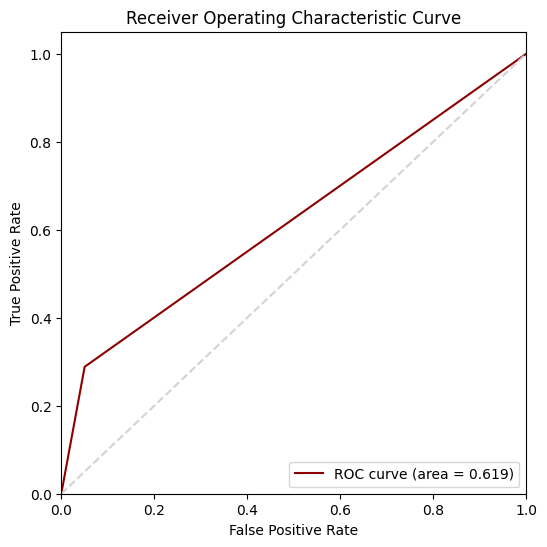

In [ ]:
xgbr = XGBClassifier(
    random_state = 1,
    n_jobs = -1,
    scale_pos_weight = 20,
    eval_metric = 'logloss'
)
xgbr.fit(X_train, y_train)
eval_result(xgbr, X_test, y_test,validation= True)

### XGBoost on fake + augmented data : AUC = 0.97


               precision    recall  f1-score   support

   Not Fraud       0.99      0.97      0.98      2902
       Fraud       0.91      0.97      0.94       894

    accuracy                           0.97      3796
   macro avg       0.95      0.97      0.96      3796
weighted avg       0.97      0.97      0.97      3796
 



,Predicted Not Fraud,Predicted Fraud
Not Fraud,2821,81
Fraud,29,865


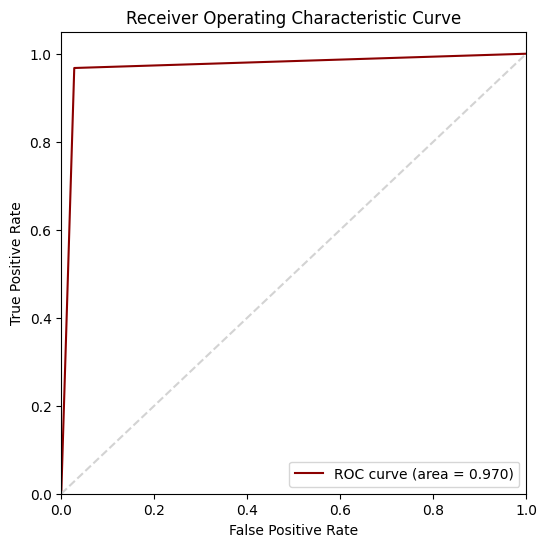

In [ ]:
xgbr2 = XGBClassifier(
    random_state = 1,
    n_jobs = -1,
    scale_pos_weight = 20,
    eval_metric = 'logloss'
)
xgbr2.fit(X_train_s, y_train_s)
eval_result(xgbr2, X_test_s, y_test_s,validation= True)